In [1]:
torch.setdefaulttensortype('torch.FloatTensor')
require 'cutorch'

exact = true

### Load Cityscapes dataset

In [1]:
package.loaded.cityscapes = nil
cityscapes = require 'cityscapes'

cityscapes.relative = '/media/Raid/e_burkov/Datasets/Cityscapes/'
nClasses = cityscapes.nClasses -- 19

trainFiles = cityscapes.loadNames('train')
valFiles = cityscapes.loadNames('val')

In [3]:
cityscapes.dsize = {1024, 512}

### Render labels for displaying

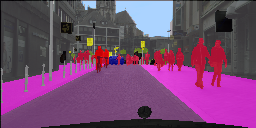

In [4]:
-- example blending
local k = 19
local img, labels = cityscapes.loadSample(trainFiles[k])
itorch.image(cityscapes.renderLabels(labels, img))

In [5]:
IntegralSmartNorm = nil
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['IntegralSmartNorm'] = nil

require 'IntegralSmartNorm'

In [6]:
local modelName = 'romera2017'
net = assert(loadfile('Models/' .. modelName .. '.lua'))(cityscapes.dsize[1], cityscapes.dsize[2], nClasses)

ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
end

require 'cunn'
net:cuda()
collectgarbage()

In [7]:
math.randomseed(666)
torch.manualSeed(666)
if CUDA then cutorch.manualSeed(666) end

net:reset()
params, gradParams = net:parameters()

In [8]:
require 'optim'

datasetIdx = 1

optimStates = {}
    
local intParamsCount = 0

for i = 1,#params do
    local lr = 1e-3
    local wd = 1e-4

    for k = 1,#ints do
        if 
            params[i] == ints[k].xMin or
            params[i] == ints[k].xMax or
            params[i] == ints[k].yMin or
            params[i] == ints[k].yMax then

            wd = 0
            lr = lr * 100
            intParamsCount = intParamsCount + 1
            break
        end
    end

    optimStates[i] = {
        learningRate = lr,
        momentum = 0.9,
        nesterov = false,
        dampening = 0,
        learningRateDecay = 0,
        weightDecay = wd
    }
end

print('Number of IntegralSmartNorm parameter tensors: ' .. intParamsCount)

Number of IntegralSmartNorm parameter tensors: 12	


In [9]:
outputDir = 'Cityscapes segmentation/GPU template test/'
os.execute('mkdir "' .. outputDir .. 'Images/train" -p')
os.execute('mkdir "' .. outputDir .. 'Images/val" -p')

In [10]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

wDebs = (#ints > 0) and {} or nil
for k = 1,#ints do wDebs[k] = WindowDebugger() end

In [11]:
require 'optim'

onlineLossLogger = optim.Logger(outputDir .. 'onlineLossLog.log')
evalLogger = optim.Logger(outputDir .. 'evalLog.log')
evalAccLogger = optim.Logger(outputDir .. 'evalAccLog.log')

onlineLossLogger:setNames{'Online batch loss'}
evalLogger:setNames{'Train loss', 'Validation loss'}
evalAccLogger:setNames{
    'Train IoU class', 'Train IoU category',
    'Validation IoU class', 'Validation IoU category'}

onlineLossLogger:style{'-'}
evalLogger:style{'-', '-'}
evalAccLogger:style{'+-', '-', '+-', '-'}

onlineLossLogger.showPlot = false
evalLogger.showPlot = false
evalAccLogger.showPlot = false

In [12]:
-- Load a saved model
error()
require 'nngraph'
require 'cunn'

net = torch.load(outputDir .. 'net.t7')
ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
end

params, gradParams = net:parameters()

require 'optim'

if paths.filep(outputDir .. 'optimState.t7') then
    optimStates = torch.load(outputDir .. 'optimState.t7')
else
    optimStates = {}
    
    local intParamsCount = 0
    
    for i = 1,#params do
        local lr = 1e-3
        local wd = 1e-4
        
        for k = 1,#ints do
            if 
                params[i] == ints[k].xMin or
                params[i] == ints[k].xMax or
                params[i] == ints[k].yMin or
                params[i] == ints[k].yMax then
               
                wd = 0
                lr = lr * 100
                intParamsCount = intParamsCount + 1
                break
            end
        end

        optimStates[i] = {
            learningRate = lr,
            momentum = 0.9,
            nesterov = false,
            dampening = 0,
            learningRateDecay = 0,
            weightDecay = wd
        }
    end
    
    print('Number of IntegralSmartNorm parameter tensors: ' .. intParamsCount)
end

datasetIdx = 1

for k = 1,#ints do wDebs[k]:load(outputDir .. 'wd' .. k .. '.t7') end

if paths.filep(outputDir .. 'evalLogger.t7') then
    evalLogger.symbols = torch.load(outputDir .. 'evalLogger.t7')
end
if paths.filep(outputDir .. 'evalAccLogger.t7') then
    evalAccLogger.symbols = torch.load(outputDir .. 'evalAccLogger.t7')
end
if paths.filep(outputDir .. 'onlineLossLogger.t7') then
    onlineLossLogger.symbols = torch.load(outputDir .. 'onlineLossLogger.t7')
end

Unknown Error: 

In [13]:
-- Measure forward/backward propagation time
input = torch.CudaTensor(1, 3, cityscapes.dsize[2], cityscapes.dsize[1]):fill(0.1)
local exactTest = true

for k = 1,#ints do
    ints[k].exact = exactTest
end

timer = torch.Timer()
for k = 1,1 do
    net:forward(input)
--     net:backward(input, net.output:clone())
end
cutorch.synchronize()

for k = 1,#ints do
    ints[k].exact = exact
end

print('Average time for 1 forward pass: ' .. (timer:time().real) .. ' seconds. Output size:')
print(net.output:size())

collectgarbage()

Average time for 1 forward pass: 0.028585910797119 seconds. Output size:	
     1
 32768
    19
[torch.LongStorage of size 3]



In [14]:
criterion = nn.CrossEntropyCriterion(cityscapes.classWeights, true):cuda()
criterion.nll.ignoreIndex = 255

In [15]:
function predict(net, example)
    local pred = net:forward(nn.utils.addSingletonDimension(example:type(net.modules[1]:type())))
    return select(2, pred[1]:view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses):max(3)):squeeze():float()
end

function comparePredictions(imgIn, labels, prediction, omitOriginal)
    -- tmp buffer for comparePredictions()
    local img = torch.FloatTensor(3, cityscapes.dsize[2], cityscapes.dsize[1])
    img:copy(imgIn)

    img:add(-img:min())
    img:div(img:max())

    local retval

    if omitOriginal then
        retval = torch.ones(3, img:size(2)*2 + 2, img:size(3))

        retval[{{}, {1, img:size(2)}, {}}]:copy(cityscapes.renderLabels(labels, img))
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2)*3 + 4, img:size(3))
        retval[{{}, {1, img:size(2)}, {}}]:copy(img)
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(labels, img, 0.8))
        retval[{{}, {img:size(2)*2+5, retval:size(2)}, {}}]:copy(cityscapes.renderLabels(prediction, img, 0.8))
    end

    collectgarbage()

    return retval
end

In [16]:
evaluationIdxVal = {
    025, 050, 075, 100, 125, 150, 175, 200, 225, 250, 
    275, 300, 325, 350, 375, 400, 425, 450, 475, 500
}

evaluationIdxTrain = {
    0150, 0300, 0450, 0600, 0750, 0900, 1050, 1200, 1350, 1500,
    1650, 1800, 1950, 2100, 2250, 2400, 2550, 2700, 2850, 2975
}

-- table.sort(evaluationIdx)

In [17]:
function evaluate(net, files, indices, outPath)
    local threadLog = {write=function()end, close=function()end, flush=function()end}
    -- local threadLog = io.open(outputDir .. 'threadLog.txt', 'w')
    
    local losses = {}
    local avgLoss = 0
    local confMatrix = torch.LongTensor(cityscapes.nClasses, cityscapes.nClasses):zero()
    
    -- Asynchronous image loading
    threads = require 'threads'
    threads.serialization('threads.sharedserialize')
    threads.Threads.serialization('threads.sharedserialize')
    require 'Queue'
    local queue = Queue() -- a queue of preprocessed input images
    local qMutex = threads.Mutex()
    queue.put = threads.safe(queue.put, qMutex)
    queue.get = threads.safe(queue.get, qMutex)
    local loadNThreads, saveNThreads = 8, 16
    local nJobs = 0 -- number of images that are either in production or not yet consumed
    local relative = cityscapes.relative
    
    local loadPool = threads.Threads(
        loadNThreads,
        function(threadId)
            (require 'sys').sleep((threadId-1) / 20)
            cityscapes = require 'cityscapes'

            cityscapes.relative = relative
            cityscapes.dsize = {1024, 512}
            nClasses = cityscapes.nClasses -- 19

            threadFiles = files
        end,

        function(threadId)
--             print('Launching thread #' .. threadId)
        end
    )
    
    local _comparePred = comparePredictions
    local _dsize = cityscapes.dsize
    
    local savePool = outPath and threads.Threads(
        saveNThreads,
        function(threadId)
            (require 'sys').sleep((threadId-1) / 20)
            require 'image'
            cityscapes = require 'cityscapes'
            cityscapes.dsize = _dsize
            
            comparePred = _comparePred
        end,

        function(threadId)
--             print('Launching thread #' .. threadId)
        end
    )
    
    local indicesIdx = 1
    
    for _ = 1,#indices do
        -- add asynchronous image loading tasks
        while indicesIdx <= #indices and nJobs < 10 do
            threadLog:write('Add,nJobs=' .. nJobs .. '\n'); threadLog:flush()
            loadPool:addjob(
                function(nextFileIdx)
                    local input, target =
                        cityscapes.loadSample(threadFiles[nextFileIdx])

                    target = target:view(cityscapes.dsize[1]*cityscapes.dsize[2])

                    collectgarbage()

                    return nextFileIdx, input, target
                end,

                function(nextFileIdx, input, target)
                    queue:put({nextFileIdx, input, target})
                    collectgarbage()
                end,
                
                indices[indicesIdx]
            )
            indicesIdx = indicesIdx + 1
            nJobs = nJobs + 1
        end

        if queue:empty() then
            threadLog:write('Q empty\n'); threadLog:flush()
            loadPool:dojob()
        end

        if queue:empty() then -- should never enter this
            threadLog:write('Q empty again\n'); threadLog:flush()
            os.execute('touch "' .. outputDir .. 'QEMPTY"')
            while queue:empty() do end
        end

        local idx, img, labels = table.unpack(queue:get())
        nJobs = nJobs - 1
        threadLog:write('Consume\n'); threadLog:flush()
        local input = img:cuda()
        local outputs = net:forward(nn.utils.addSingletonDimension(input))[1] -- 13999 x 19
        
        local predictedLabels = 
            select(2, outputs:view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses)
                :max(3)):squeeze():long()
        
        if savePool then
            savePool:addjob(
                function(idx, input, labels, predictedLabels)
                    image.savePNG(
                        outPath .. string.format('/%04d.png', idx), 
                        comparePred(input, labels, predictedLabels))
                    collectgarbage()
                end,
                function() end,
                
                idx, img, labels, predictedLabels
            )
        end
        
        cityscapes.updateConfusionMatrix(confMatrix, predictedLabels, labels)
        
        labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])

        local loss = criterion:forward(outputs, labels:view(-1):cudaByte())
        -- dumb way to find idx
        for i = 1,#indices do
            if indices[i] == idx then
                losses[i] = loss
                break
            end
        end
        avgLoss = avgLoss + loss
    end
    
    local IoUclassAvg, IoUcategoryAvg = cityscapes.calcIoU(confMatrix)
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    loadPool:terminate()
    qMutex:free()
    if savePool then
        savePool:terminate()
    end
    threadLog:close()
    
    return avgLoss, IoUclassAvg, IoUcategoryAvg, losses, confMatrix
end

## Training loop

In [18]:
-- threadLog = io.open(outputDir .. 'threadLog.txt', 'w')
threadLog = {write=function()end, close=function()end, flush=function()end}

batchSize = 2
shuffleEvery = math.ceil(#trainFiles / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 100 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 2 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 500 -- how often to save `net` and `windowDebugger`s

-- Asynchronous image loading
threads = require 'threads'
threads.serialization('threads.sharedserialize')
threads.Threads.serialization('threads.sharedserialize')
require 'Queue'
local queue = Queue() -- a queue of preprocessed input images
local qMutex = threads.Mutex()
queue.put = threads.safe(queue.put, qMutex)
queue.get = threads.safe(queue.get, qMutex)
local nThreads = 8
local nJobs = 0 -- number of images that are either in production or not yet consumed

local _dsize = cityscapes.dsize
local _trainFiles = trainFiles

local pool = threads.Threads(
    nThreads,
    function(threadId)
        (require 'sys').sleep((threadId-1) / 3)
        require 'image'
        require 'Queue'
        threadTrainFiles = _trainFiles
        cityscapes = require 'cityscapes'

        cityscapes.relative = '/media/Raid/e_burkov/Datasets/Cityscapes/'
        cityscapes.dsize = _dsize
        nClasses = cityscapes.nClasses -- 19
    end,

    function(threadId)
        print('Launching thread #' .. threadId)
    end
)

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,#trainFiles do
    idx[i] = i
end

local avgLoss = 0

net:training()

batch = torch.CudaTensor(batchSize, 3, cityscapes.dsize[2], cityscapes.dsize[1])
batchLabels = torch.CudaByteTensor(batchSize, cityscapes.dsize[1]*cityscapes.dsize[2])
batchCPU, batchLabelsCPU = batch:float(), batchLabels:float()

for iter = 1,1e7 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    if wDebs and (iter-1) % 50 == 0 then
        for k = 1,#wDebs do
            wDebs[k]:add(ints[k])
        end
    end
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        
        torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
        torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
        torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)
        torch.save(outputDir .. 'optimState.t7', optimStates)
    end
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do
            -- add asynchronous image loading tasks
            while nJobs < 10 do
                threadLog:write('Add,nJobs=' .. nJobs .. '\n'); threadLog:flush()

                pool:addjob(
                    function(nextFileIdx)
                        local input, target = --jitter(
                            cityscapes.loadSample(threadTrainFiles[nextFileIdx])
    --                         images[idx[datasetIdx]], 
    --                         labels[idx[datasetIdx]]
    --                         torch.random() % 2 == 0)

                        if torch.random() % 2 == 0 then
                            input = image.flip(input, 3)
                            target = image.flip(target, 2)
                        else
                            target = target:clone()
                        end

                        target = target:view(cityscapes.dsize[1]*cityscapes.dsize[2])
                        
                        collectgarbage()

                        return input, target
                    end,

                    function(input, target)
                        queue:put({input, target})
                        collectgarbage()
                    end,
                    
                    idx[datasetIdx]
                )
                datasetIdx = datasetIdx % #trainFiles + 1
                nJobs = nJobs + 1
            end

            if queue:empty() then
                threadLog:write('Q empty\n'); threadLog:flush()
                pool:dojob()
            end

            if queue:empty() then -- should never enter this
                threadLog:write('Q empty again\n'); threadLog:flush()
                os.execute('touch "' .. outputDir .. 'QEMPTY"')
                while queue:empty() do end
            end

            local input, target = table.unpack(queue:get())
            nJobs = nJobs - 1
            threadLog:write('Consume\n'); threadLog:flush()

            batchCPU[k]:copy(input)
            batchLabelsCPU[k]:copy(target)
        end
        
        batch:copy(batchCPU)
        batchLabels:copy(batchLabelsCPU)
        
        local outputs = net:forward(batch) -- 2 x 13999 x 19
        
        batchLoss = criterion:forward(outputs:view(-1, nClasses), batchLabels:view(-1))
        criterion:backward(outputs:view(-1, nClasses), batchLabels:view(-1))
        net:backward(batch, criterion.gradInput:view(batchSize,-1,nClasses)) -- accumulate gradients
    end
    
    -- detect NaNs
    local function hasNaN(x) return x:ne(x):sum() > 0 end
    if batchLoss ~= batchLoss then -- or hasNaN(net.output) then
        break
    end
    
    onlineLossLogger:add{batchLoss}
    if iter % 10 == 0 then onlineLossLogger:plot() end
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        net:evaluate()
        
        local trainLoss, trainIOUclass, trainIOUcategory = 
            evaluate(net, trainFiles, evaluationIdxTrain,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/train/'))
        
        local valLoss, valIOUclass, valIOUcategory = 
            evaluate(net, valFiles, evaluationIdxVal,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/val/'))
        
        evalLogger:add{trainLoss, valLoss}
        evalLogger:plot()
        evalAccLogger:add{trainIOUclass, trainIOUcategory, valIOUclass, valIOUcategory}
        evalAccLogger:plot()
        
        net:training()
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

pool:terminate()
qMutex:free()
threadLog:close()

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:save(outputDir .. 'wd' .. k .. '.t7')
    end
end

collectgarbage()

Epoch 0	


In [24]:
-- do this after INTERRUPTing
net:clearState()
torch.save(outputDir .. 'net.t7', net)

torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)
torch.save(outputDir .. 'optimState.t7', optimStates)

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:exportVideo(outputDir .. 'int-layer-' .. k .. '.avi')
    end
end

## Export images for evaluation by `cityscapesScripts`

In [31]:
function getResultFilename(s)
    local slashIdx = s:find('/')
    s = s:sub(slashIdx+1, -1)
    local slashIdx = s:find('/')
    return s:sub(slashIdx+1, -16) .. 'result.png'
end

print('Total ' .. #valFiles)

os.execute('mkdir "' .. cityscapes.relative .. 'results" -p')
for k = 1,#valFiles do
    if k % 50 == 0 then print(k) end
    
    local img, labels = cityscapes.loadSample(valFiles[k])

    local input = img:cuda()
    local outputs = net:forward(nn.utils.addSingletonDimension(input))[1]
    local outLabels = 
        select(2, outputs:float():view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses)
            :max(3)):squeeze()
    local outLabelsEval = cityscapes.labelsToEval(outLabels)
    
--     itorch.image(outLabelsEval)
    image.savePNG(
        cityscapes.relative .. 'results/' .. getResultFilename(valFiles[k].image), 
        image.scale(outLabelsEval, '*8', 'simple'))
end

Total 500	


50	


100	


150	


200	


250	


300	


350	


400	


450	


500	
